### import packages

In [11]:
import os
import sys
import abc
import random
import math
import copy
from collections import deque, namedtuple
from typing import List, Tuple
import attr
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim


# Determine the project root directory (adjust the path as necessary)
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../../../..'))
print(project_root)
sys.path.append(project_root)

from scipy.optimize import fsolve, minimize
from price_simulator.src.algorithm.demand import MarketDemandStrategy, LogitDemand, PrisonersDilemmaDemand
from price_simulator.src.algorithm.agents.simple import AgentStrategy
from price_simulator.src.algorithm.equilibrium import EquilibriumCalculator
from price_simulator.src.utils.storage import Storage

c:\Users\Thomas Gausmann\sciebo - Gausmann, Thomas (t_gaus04@uni-muenster.de)@uni-muenster.sciebo.de\Masterarbeit\price_simulator


## Algorithm Related

### Simple Strategies

In [2]:
@attr.s
class AgentStrategy(metaclass=abc.ABCMeta):
    """Top-level interface for Price setting agents"""

    marginal_cost: float = attr.ib(default=1.0)
    quality: float = attr.ib(default=2.0)

    @marginal_cost.validator
    def check_marginal_costs(self, attribute, value):
        if not value >= 0.0:
            raise ValueError("Marginal costs must be positive")

    @quality.validator
    def check_quality_costs(self, attribute, value):
        if not self.marginal_cost <= value:
            raise ValueError("Quality must be at least as high as marginal costs to be active in market")

    @abc.abstractmethod
    def play_price(self, state, action_space, n_period, t):
        raise NotImplementedError

    @abc.abstractmethod
    def learn(
        self,
        previous_reward: float,
        reward: float,
        previous_action: float,
        action: float,
        action_space: List,
        previous_state: Tuple,
        state: Tuple,
        next_state: Tuple,
    ):
        raise NotImplementedError

    def who_am_i(self) -> str:
        return type(self).__name__


#### Always Defect Agent

In [3]:
@attr.s
class AlwaysDefectAgent(AgentStrategy):
    """Agent that always defects"""

    def play_price(self, state: Tuple, action_space: List, n_period: int, t: int):
        """Always play the lowest possible price."""
        return min(action_space)

    def learn(
        self,
        previous_reward: float,
        reward: float,
        previous_action: float,
        action: float,
        action_space: List,
        previous_state: Tuple,
        state: Tuple,
        next_state: Tuple,
    ):
        pass


#### TitForTat Agent

In [49]:
@attr.s
class TitForTat(AlwaysDefectAgent):
    """
    Tit for Tat Agent.

    If opponent undercut last period play lowest price.
    Otherwise play opponent last periods price.
    Agent must be second in list. Only two agents possible.

    """

    def play_price(self, state: Tuple, action_space: List, n_period: int, t: int):
        if state[0] < state[1]:
            return min(action_space)
        else:
            return state[0]

### Demand

In [4]:
@attr.s
class MarketDemandStrategy(metaclass=abc.ABCMeta):
    """Top-level interface for all market demand modulation."""

    @abc.abstractmethod
    def get_quantities(self, prices: Tuple, qualities: Tuple) -> Tuple:
        """Return demand quanities for each price"""
        raise NotImplementedError()


#### Logit Demand

In [5]:
@attr.s
class LogitDemand(MarketDemandStrategy):
    """Market demand modulation for logit demand"""

    price_sensitivity: float = attr.ib(0.25)  # lower more sensitive
    outside_quality: float = attr.ib(0.0)

    @price_sensitivity.validator
    def check_price_sensitivity(self, attribute, value):
        if not 0.005 <= value:
            raise ValueError("Price Sensitivity must lie above 0.005")

    def get_quantities(self, prices: Tuple, qualities: Tuple) -> Tuple:
        denominator = sum((math.exp((a - p) / self.price_sensitivity) for a, p in zip(qualities, prices))) + math.exp(
            self.outside_quality / self.price_sensitivity
        )
        return tuple(math.exp((a - p) / self.price_sensitivity) / denominator for a, p in zip(qualities, prices))


### Policies (Exploration)

In [6]:
@attr.s
class ExplorationStrategy(metaclass=abc.ABCMeta):
    """Top-level interface for Exploration decision."""

    def who_am_i(self) -> str:
        return type(self).__name__

    def epsilon(self, length: int, time: int) -> float:
        raise NotImplementedError

    def explore(self, n_period: int, t: int) -> bool:
        epsilon = self.epsilon(n_period, t)
        return random.choices([True, False], weights=[epsilon, 1 - epsilon])[0]


#### Decreasing Epsilon

In [7]:
@attr.s
class DecreasingEpsilonGreedy(ExplorationStrategy):
    """
    Exploration decision with decreasing epsilon.
    Adapts dynamically to different simulation lengths

    """

    beta: float = attr.ib(default=0.015)

    def epsilon(self, length: int, time: int) -> float:
        """Returns epsilon for time step, such that after half of the time epsilon is 0.001"""
        return (self.beta ** (1.0 / (length / 2))) ** time


## Economic Environment
### Equilibrium

In [8]:
@attr.s
class EquilibriumCalculator(object):
    """Find equilibrium (Monopoly and Nash) for market environment specified by marginal costs, qualities and demand."""

    demand: MarketDemandStrategy = attr.ib()

    def get_nash_equilibrium(self, qualities: List, marginal_costs: List) -> np.array:
        """Calculate prices that makes market outcome an equilibrium"""
        param = (qualities, marginal_costs)
        p0 = np.array(marginal_costs)
        return fsolve(self.vector_reaction, p0, args=param)

    def profit(
        self, own_price: float, prices: np.array, qualities: np.array, marginal_costs: np.array, i: int
    ) -> float:
        """Calculate profit for ith firm if it sets his price to own_price given competitor prices."""
        temp_prices = copy.deepcopy(prices)
        temp_prices[i] = own_price
        return -1 * (temp_prices[i] - marginal_costs[i]) * self.demand.get_quantities(temp_prices, qualities)[i]

    def reaction_function(self, prices: np.array, qualities: np.array, marginal_costs: np.array, i: float) -> float:
        """Get price (optimal reaction) that maximizes own profit for given competitor prices."""
        return minimize(
            fun=self.profit,
            x0=np.array(marginal_costs[i]),
            args=(prices, qualities, marginal_costs, i),
            method="nelder-mead",
            options={"xatol": 1e-8},
        ).x[0]

    def vector_reaction(self, nash_prices: np.array, qualities: np.array, marginal_costs: np.array) -> np.array:
        """Vector representation of the fix-point for Nash prices."""
        return np.array(nash_prices) - np.array(
            [self.reaction_function(nash_prices, qualities, marginal_costs, i) for i in range(len(nash_prices))]
        )

    def get_monopoly_outcome(self, qualities: List, marginal_costs: List) -> np.array:
        """Get prices that maximize joint profit."""
        return minimize(
            fun=self.joint_profit,
            x0=np.array(qualities),
            args=(qualities, marginal_costs),
            method="nelder-mead",
            options={"xatol": 1e-8},
        ).x

    def joint_profit(self, prices: np.array, qualities: np.array, marginal_costs: np.array) -> float:
        """Return (negative) joint profit for prices."""
        return -1 * np.sum(
            np.multiply(np.subtract(prices, marginal_costs), self.demand.get_quantities(prices, qualities))
        )


### Storage

In [9]:
@attr.s
class Storage:
    counter = attr.ib(default=0)
    update_steps = attr.ib(init=False)
    running_rewards = attr.ib(init=False)
    running_quantities = attr.ib(init=False)
    running_actions = attr.ib(init=False)
    average_rewards = attr.ib(default=None)
    average_quantities = attr.ib(default=None)
    average_actions = attr.ib(default=None)

    def set_up(self, n_agents: int, n_periods: int, desired_length: int = 1000):
        self.reset_running_storage(n_agents)
        self.update_steps = max(1, np.round(n_periods / desired_length, 0))

    def reset_running_storage(self, n_agents: int):
        self.running_rewards = np.array([0] * n_agents)
        self.running_quantities = np.array([0] * n_agents)
        self.running_actions = np.array([0] * n_agents)

    def observe(self, rewards: np.array, actions: np.array, quantities: np.array):
        self.counter += 1
        self.running_rewards = self.incremental_update(rewards, self.running_rewards, self.counter)
        self.running_quantities = self.incremental_update(quantities, self.running_quantities, self.counter)
        self.running_actions = self.incremental_update(actions, self.running_actions, self.counter)

        if self.counter == self.update_steps:
            if self.average_actions is not None:
                self.average_rewards = np.vstack([self.average_rewards, self.running_rewards])
                self.average_actions = np.vstack([self.average_actions, self.running_actions])
                self.average_quantities = np.vstack([self.average_quantities, self.running_quantities])
            else:
                self.average_rewards = copy.deepcopy(self.running_rewards)
                self.average_actions = copy.deepcopy(self.running_actions)
                self.average_quantities = copy.deepcopy(self.running_quantities)

            self.reset_running_storage(len(rewards))
            self.counter = 0

    @staticmethod
    def incremental_update(observation: np.array, average: np.array, cnt: int) -> np.array:
        return average + (observation - average) / cnt

    def print(self):
        print("Rewards:", self.average_rewards)
        print("Prices:", self.average_actions)
        print("Quantities:", self.average_quantities)


### Environment

In [10]:
@attr.s
class EnvironmentStrategy(metaclass=abc.ABCMeta):
    """Top-level interface for Environment."""

    agents: List[AgentStrategy] = attr.ib(factory=list)
    possible_prices: List[float] = attr.ib(factory=list)
    demand: MarketDemandStrategy = attr.ib(factory=LogitDemand)
    nash_prices: np.array = attr.ib(init=False)
    monopoly_prices: np.array = attr.ib(init=False)

    def __attrs_post_init__(self):
        """Compute Nash Price and Monopoly price after initialization."""
        if len(self.agents) > 0.0:
            if isinstance(self.demand, PrisonersDilemmaDemand):
                assert len(self.possible_prices) > 0.0, "Priosoners Dilemma needs two possible prices"
                self.monopoly_prices = [max(self.possible_prices), max(self.possible_prices)]
                self.nash_prices = np.array([min(self.possible_prices), min(self.possible_prices)])
            else:
                marginal_costs = [agent.marginal_cost for agent in self.agents]
                qualities = [agent.quality for agent in self.agents]
                self.monopoly_prices = EquilibriumCalculator(demand=self.demand).get_monopoly_outcome(
                    qualities, marginal_costs
                )
                self.nash_prices = EquilibriumCalculator(demand=self.demand).get_nash_equilibrium(
                    qualities, marginal_costs
                )

    @abc.abstractmethod
    def play_game(self):
        raise NotImplementedError


@attr.s
class DiscreteSynchronEnvironment(EnvironmentStrategy):
    """Environment for discrete states and prices.

     Before the first iteration, prices are randomly initialized.
     Agents set prices at the same time.
     After choosing prices, demand and rewards are calculated.
     Then agents have the opportunity to learn.
     """

    n_periods: int = attr.ib(default=1)
    markup: float = attr.ib(default=0.1)
    n_prices: int = attr.ib(default=15)
    convergence_after: int = attr.ib(default=np.inf)
    history_after: int = attr.ib(default=np.inf)
    price_history: List = attr.ib(factory=list)
    quantity_history: List = attr.ib(factory=list)
    reward_history: List = attr.ib(factory=list)
    storage: Storage = attr.ib(factory=Storage)

    @n_periods.validator
    def check_n_periods(self, attribute, value):
        if not 0 < value:
            raise ValueError("Number of periods must be strictly positive")

    @markup.validator
    def check_markup(self, attribute, value):
        if not 0 <= value:
            raise ValueError("Price markup must be positive")

    @n_prices.validator
    def check_n_prices(self, attribute, value):
        if not 0 < value:
            raise ValueError("Number of prices must be strictly positive")

    def play_game(self) -> int:

        qualities = tuple(agent.quality for agent in self.agents)
        marginal_costs = tuple(agent.marginal_cost for agent in self.agents)

        # initialize first rounds
        if len(self.possible_prices) == 0:
            self.possible_prices = self.get_price_range(
                min(self.nash_prices), max(self.monopoly_prices), self.markup, self.n_prices
            )
        previous_state = tuple(random.choices(self.possible_prices, k=len(self.agents)))
        state = tuple(
            agent.play_price(previous_state, self.possible_prices, self.n_periods, 0) for agent in self.agents
        )
        quantities = self.demand.get_quantities(state, qualities)
        previous_rewards = np.multiply(np.subtract(state, marginal_costs), quantities)

        # set up storage
        self.storage.set_up(len(self.agents), self.n_periods)

        for t in range(self.n_periods):
            # Progress indicator
            if t % max(1, self.n_periods // 100) == 0:
                print(f"Period {t}/{self.n_periods} ({(t / self.n_periods) * 100:.2f}%)")
                
            # agents decide about there prices (hereafter is the state different)
            next_state = tuple(
                agent.play_price(state, self.possible_prices, self.n_periods, t) for agent in self.agents
            )

            # demand is estimated for prices
            quantities = self.demand.get_quantities(next_state, qualities)
            rewards = np.multiply(np.subtract(next_state, marginal_costs), quantities)

            # assert that everything is correct
            assert (np.array(quantities) >= 0.0).all(), "Quantities cannot be negative"
            assert (np.array(next_state) >= 0.0).all(), "Prices cannot be negative"

            # agents learn
            for agent, action, previous_action, reward, previous_reward in zip(
                self.agents, next_state, state, rewards, previous_rewards
            ):
                agent.learn(
                    previous_reward=previous_reward,
                    reward=reward,
                    previous_action=previous_action,
                    action=action,
                    action_space=self.possible_prices,
                    previous_state=previous_state,
                    state=state,
                    next_state=next_state,
                )

            # update variables
            previous_state = copy.deepcopy(state)
            state = copy.deepcopy(next_state)
            previous_rewards = copy.deepcopy(rewards)

            # save prices for the last periods
            if t > self.history_after:
                self.price_history.append(previous_state)
                self.quantity_history.append(quantities)
                self.reward_history.append(rewards)

            # Fill storage
            self.storage.observe(rewards, state, quantities)

        return t

    @staticmethod
    def get_price_range(nash_price: float, monopoly_price: float, markup: float, n_step: int) -> List:
        increase = (monopoly_price - nash_price) * markup
        return list(np.linspace(nash_price - increase, monopoly_price + increase, n_step))


## Quick Test with 2 Always defect agents

In [ ]:
# Test the AlwaysDefectAgent

def create_subplot(data, label):
    for series in data:
        plt.plot(series, label=label)
    plt.legend()

def test_always_defect_agent():
    # Create an environment with AlwaysDefectAgent
    env = DiscreteSynchronEnvironment(
        markup=0.1,
        n_periods=1000,
        possible_prices=[],
        n_prices=15,
        demand=LogitDemand(outside_quality=0.0, price_sensitivity=0.25),
        history_after=100,
        agents=[
            AlwaysDefectAgent(marginal_cost=1.0, quality=2.0),
            AlwaysDefectAgent(marginal_cost=1.0, quality=2.0),
        ],
    )

    # Simulate the environment
    env.play_game()

    # Analyze and visualize results
    price_history_1 = [price[0] for price in env.price_history]
    price_history_2 = [price[1] for price in env.price_history]

    # Plot price history
    plt.figure(figsize=(12, 6))
    create_subplot([price_history_1, price_history_2], label="Price")
    plt.title("Price History")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.show()

    # Plot reward history
    reward_history_1 = [reward[0] for reward in env.reward_history]
    reward_history_2 = [reward[1] for reward in env.reward_history]
    plt.figure(figsize=(12, 6))
    create_subplot([reward_history_1, reward_history_2], label="Reward")
    plt.title("Reward History")
    plt.xlabel("Time")
    plt.ylabel("Reward")
    plt.show()

test_always_defect_agent()

## LSTM implementation

### Simple LSTM Agent

In [ ]:
from price_simulator.src.algorithm.agents.buffer import SequentialReplayBuffer
from price_simulator.src.algorithm.agents.simple import AgentStrategy
from price_simulator.src.algorithm.policies import EpsilonGreedy, ExplorationStrategy

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc1(out[:, -1, :])
        out = self.fc2(out)
        return out

@attr.s
class SimpleLSTMAgent(AgentStrategy):
    """Simplified LSTM Agent using sequences of past states"""

    # LSTM Network
    lstm: LSTMModel = attr.ib(default=None)
    hidden_nodes: int = attr.ib(default=32)
    sequence_length: int = attr.ib(default=5)  # Number of past states to use
    state_history: List[Tuple[float, ...]] = attr.ib(factory=list)

    # General
    decision: ExplorationStrategy = attr.ib(factory=EpsilonGreedy)
    discount: float = attr.ib(default=0.95)
    learning_rate: float = attr.ib(default=0.1)

    loss_history: List[float] = attr.ib(factory=list, init=False)

    @discount.validator
    def check_discount(self, attribute, value):
        if not 0 <= value <= 1:
            raise ValueError("Discount factor must lie in [0,1]")

    @learning_rate.validator
    def check_learning_rate(self, attribute, value):
        if not 0 <= value < 1:
            raise ValueError("Learning rate must lie in [0,1)")

    def who_am_i(self) -> str:
        return type(self).__name__ + " (gamma: {}, alpha: {}, policy: {}, quality: {}, mc: {})".format(
            self.discount, self.learning_rate, self.decision.who_am_i(), self.quality, self.marginal_cost
        )

    def update_state_history(self, state: Tuple[float]):
        #ToDo: make more versatile to use in other agents
        if not isinstance(self.state_history, list):
            self.state_history = []
        """Update the history of states with the new state."""
        self.state_history.append(state)
        if len(self.state_history) > self.sequence_length:
            self.state_history.pop(0)

    def play_price(self, state: Tuple[float], action_space: List[float], n_period: int, t: int) -> float:
        """Returns an action by either following greedy policy or experimentation."""

        # Update state history
        self.update_state_history(state)

        # Initialize LSTM network if necessary
        if not self.lstm:
            self.lstm = self.initialize_network(len(state), len(action_space))

        # Play action
        if self.decision.explore(n_period, t):
            return random.choice(action_space)
        else:
            # Use state history as input to the LSTM network
            states_input = torch.tensor(self.scale_sequence(self.state_history, action_space)).float().unsqueeze(0)
            action_values = self.lstm(states_input).detach().numpy()
            if sum(np.isclose(action_values[0], action_values[0].max())) > 1:
                optimal_action_index = np.random.choice(
                    np.flatnonzero(np.isclose(action_values[0], action_values[0].max()))
                )
            else:
                optimal_action_index = np.argmax(action_values[0])
            return action_space[optimal_action_index]
        
    def learn(
        self,
        previous_reward: float,
        reward: float,
        previous_action: float,
        action: float,
        action_space: List[float],
        previous_state: Tuple[float],
        state: Tuple[float],
        next_state: Tuple[float],
    ):
        """Update the LSTM network based on the observed rewards and actions."""
        # Update state history with the current state
        self.update_state_history(state)

        # Create a sequence of state history length for the next state
        next_state_history = self.state_history[-self.sequence_length:] + [next_state]
        # Scale the input sequences
        states_input = torch.tensor(self.scale_sequence(self.state_history, action_space)).float().unsqueeze(0)
        next_states_input = torch.tensor(self.scale_sequence(next_state_history, action_space)).float().unsqueeze(0)

        # Compute the target Q-values using the Bellman equation
        next_optimal_q = self.lstm(next_states_input).max().item()
        target = reward + self.discount * next_optimal_q

        # Get the local estimates from the LSTM network
        local_estimates = self.lstm(states_input)
        action_idx = np.atleast_1d(action_space == action).nonzero()[0]
        target_tensor = local_estimates.clone().detach()
        target_tensor[0, action_idx] = target

        # Update the LSTM network using backpropagation
        optimizer = optim.Adam(self.lstm.parameters(), lr=self.learning_rate)
        optimizer.zero_grad()
        loss = nn.MSELoss()(local_estimates, target_tensor)
        loss.backward()
        optimizer.step()
        # Store the loss value
        self.loss_history.append(loss.item())
        # Debugging: ###print loss and target values
        #print(f"Loss: {loss.item()}, Target: {target}, Local Estimates: {local_estimates[0, action_idx].item()}")

    def initialize_network(self, n_agents: int, n_actions: int):
        """Create a neural network with one output node per possible action"""
        return LSTMModel(input_size=n_agents, hidden_size=self.hidden_nodes, output_size=n_actions)

    def scale_sequence(self, sequences: List[Tuple], action_space: List) -> np.array:
        """Scale float input sequences to range from 0 to 1."""
        max_action = max(action_space)
        min_action = min(action_space)
        return np.array([
            np.multiply(np.divide(np.array(seq) - min_action, max_action - min_action), 1) for seq in sequences
        ])
    


### Test Simple LSTM Agent

In [ ]:
def test_simple_lstm_vs_always_defect():
    # Create an environment with one SimpleLSTMAgent and one AlwaysDefectAgent
    env = DiscreteSynchronEnvironment(
        markup=0.1,
        n_periods=10000,
        possible_prices=[],
        n_prices=15,
        demand=LogitDemand(outside_quality=0.0, price_sensitivity=0.25),
        history_after=100,
        agents=[
            SimpleLSTMAgent(
                discount=0.95, learning_rate=0.001, decision=DecreasingEpsilonGreedy(), marginal_cost=1.0, quality=2.0, state_history = 50
            ),
            AlwaysDefectAgent(
                
            ),
        ],
    )

    # Simulate the environment
    env.play_game()

    # Analyze and visualize results
    price_history_lstm = [price[0] for price in env.price_history]
    price_history_defect = [price[1] for price in env.price_history]

    # Plot price history
    plt.figure(figsize=(12, 6))
    plt.plot(price_history_lstm, label="Simple LSTM Agent")
    plt.plot(price_history_defect, label="Always Defect Agent")
    plt.title("Price History: Simple LSTM Agent vs Always Defect Agent")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

    # Plot reward history
    reward_history_lstm = [reward[0] for reward in env.reward_history]
    reward_history_defect = [reward[1] for reward in env.reward_history]
    plt.figure(figsize=(12, 6))
    plt.plot(reward_history_lstm, label="Simple LSTM Agent")
    plt.plot(reward_history_defect, label="Always Defect Agent")
    plt.title("Reward History: Simple LSTM Agent vs Always Defect Agent")
    plt.xlabel("Time")
    plt.ylabel("Reward")
    plt.legend()
    plt.show()

test_simple_lstm_vs_always_defect()

### Replaybuffer

In [ ]:

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size=None):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            seed (int): random seed
        """
        if buffer_size is None:
            self.buffer_size = 10000
        self.memory = deque(maxlen=buffer_size)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state"])

    def add(self, state, action, reward, next_state):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state)
        self.memory.append(e)

    def sample(self, batch_size):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=batch_size)

        states = np.vstack([e.state for e in experiences if e is not None])
        actions = np.vstack([e.action for e in experiences if e is not None])
        rewards = np.vstack([e.reward for e in experiences if e is not None])
        next_states = np.vstack([e.next_state for e in experiences if e is not None])

        return states, actions, rewards, next_states

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)



### LSTM with only Target Network
Idea: Replaybuffer breaks correlation in sequences. But LSTM is trained to utilize these correlations, no? So, remove replaybuffer and only use Target Network

In [ ]:
@attr.s
class LSTMTargetAgent(SimpleLSTMAgent):
	"""LSTM Agent with Target Network but without Replay Buffer"""

	# Target Network
	target_network: LSTMModel = attr.ib(default=None)
	update_target_after: int = attr.ib(default=100)
	update_counter: int = attr.ib(default=0)

	def initialize_network(self, n_agents: int, n_actions: int):
		"""Initialize both local and target networks."""
		local_network = super().initialize_network(n_agents, n_actions)
		target_network = super().initialize_network(n_agents, n_actions)
		target_network.load_state_dict(local_network.state_dict())  # Synchronize weights
		self.target_network = target_network
		return local_network

	def learn(
		self,
		previous_reward: float,
		reward: float,
		previous_action: float,
		action: float,
		action_space: List[float],
		previous_state: Tuple[float],
		state: Tuple[float],
		next_state: Tuple[float],
	):
		"""Train the LSTM network using the target network."""
		# Update state history
		self.update_state_history(state)

		# Create a sequence of state history length for the next state
		next_state_history = self.state_history[-self.sequence_length:] + [next_state]
		# Scale the input sequences
		states_input = torch.tensor(self.scale_sequence(self.state_history, action_space)).float().unsqueeze(0)
		next_states_input = torch.tensor(self.scale_sequence(next_state_history, action_space)).float().unsqueeze(0)

		# Compute the target Q-values using the target network
		# ToDo maybe try advantage learning
		with torch.no_grad():
			next_optimal_q = self.target_network(next_states_input).max().item()
			target = reward + self.discount * next_optimal_q

		# Get the local estimates from the LSTM network
		local_estimates = self.lstm(states_input)
		action_idx = np.atleast_1d(action_space == action).nonzero()[0]
		target_tensor = local_estimates.clone().detach()
		target_tensor[0, action_idx] = target

		# Update the LSTM network using backpropagation
		optimizer = optim.Adam(self.lstm.parameters(), lr=self.learning_rate)
		optimizer.zero_grad()
		loss = nn.MSELoss()(local_estimates, target_tensor)
		loss.backward()
		optimizer.step()

		# Update the target network periodically
		self.update_counter += 1
		if self.update_counter >= self.update_target_after:
			self.target_network.load_state_dict(self.lstm.state_dict())
			self.update_counter = 0
			print("Target network updated.")

		# Store the loss value
		self.loss_history.append(loss.item())

In [ ]:
def test_lstm_target_vs_always_defect():
	# Create an environment with one LSTMTargetAgent and one AlwaysDefectAgent
	env = DiscreteSynchronEnvironment(
		markup=0.1,
		n_periods=10000,
		possible_prices=[],
		n_prices=15,
		demand=LogitDemand(outside_quality=0.0, price_sensitivity=0.25),
		history_after=100,
		agents=[
			LSTMTargetAgent(
				discount=0.95,
				learning_rate=0.001,
				decision=DecreasingEpsilonGreedy(),
				marginal_cost=1.0,
				quality=2.0,
				sequence_length=10,
				update_target_after=100,
			),
			AlwaysDefectAgent(
				marginal_cost=1.0,
				quality=2.0,
			),
		],
	)

	# Simulate the environment
	env.play_game()

	# Analyze and visualize results
	price_history_lstm = [price[0] for price in env.price_history]
	price_history_defect = [price[1] for price in env.price_history]

	# Plot price history
	plt.figure(figsize=(12, 6))
	plt.plot(price_history_lstm, label="LSTM Target Agent")
	plt.plot(price_history_defect, label="Always Defect Agent")
	plt.title("Price History: LSTM Target Agent vs Always Defect Agent")
	plt.xlabel("Time")
	plt.ylabel("Price")
	plt.legend()
	plt.show()

	# Plot reward history
	reward_history_lstm = [reward[0] for reward in env.reward_history]
	reward_history_defect = [reward[1] for reward in env.reward_history]
	plt.figure(figsize=(12, 6))
	plt.plot(reward_history_lstm, label="LSTM Target Agent")
	plt.plot(reward_history_defect, label="Always Defect Agent")
	plt.title("Reward History: LSTM Target Agent vs Always Defect Agent")
	plt.xlabel("Time")
	plt.ylabel("Reward")
	plt.legend()
	plt.show()

test_lstm_target_vs_always_defect()

### Sequential Replay Buffer

In [31]:

class SequentialReplayBuffer:
    """Replay buffer that stores sequences of states, actions, and rewards.
    Basic idea here: store the states, actions, and rewards as an array.
    When needed, sample based on a random index"""

    def __init__(self, buffer_size=None):
        """Initialize a SequentialReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
        """
        if buffer_size is None:
            buffer_size = 10000
        self.buffer_size = buffer_size
        self.states = deque(maxlen=buffer_size)  # Stores individual states
        self.actions = deque(maxlen=buffer_size)  # Stores actions
        self.rewards = deque(maxlen=buffer_size)  # Stores rewards

    def add(self, state, action, reward):
        """Add a new experience to memory."""
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)

    def sample(self, batch_size, sequence_length):
        """Sample a batch of sequential experiences from memory.
        Params
        ======
            batch_size: Number of sequences to sample
            sequence_length: Length of each sequence of states
        Returns
        =======
            sampled_states: Batch of sequences of states
            sampled_actions: Actions corresponding to the end of sampled_states sequence
            sampled_rewards: Rewards corresponding to the end of sampled_states sequence
            next_states: Batch of sequences of next states, shifted by one step
        """
        available_length = len(self.states)
        if available_length < sequence_length:
            print(f"Buffer has fewer entries ({available_length}) than the requested sequence length ({sequence_length}). Adjusting sequence length.")
            sequence_length = available_length

        max_start_index = available_length - sequence_length
        if max_start_index + 1 < batch_size:
            print(f"Buffer has fewer sequences ({max_start_index + 1}) than the requested batch size ({batch_size}). Adjusting batch size.")
            batch_size = max_start_index + 1

        indices = random.sample(range(max(0, max_start_index + 1)), batch_size)

        sampled_states = []
        sampled_actions = []
        sampled_rewards = []
        sampled_next_states = []

        for idx in indices:
            # Sequence of states
            state_sequence = list(self.states)[idx:idx + sequence_length]
            next_state_sequence = list(self.states)[idx + 1:idx + sequence_length + 1]

            # Pad sequences if they are shorter than the requested length
            while len(state_sequence) < sequence_length:
                state_sequence.append(np.zeros_like(state_sequence[0]))
            while len(next_state_sequence) < sequence_length:
                next_state_sequence.append(np.zeros_like(next_state_sequence[0]))

            sampled_states.append(state_sequence)
            sampled_next_states.append(next_state_sequence)

            # Action and reward at the end of the sequence
            sampled_actions.append(self.actions[idx + sequence_length - 1])
            sampled_rewards.append(self.rewards[idx + sequence_length - 1])

        return (
            np.array(sampled_states),
            np.array(sampled_actions),
            np.array(sampled_rewards),
            np.array(sampled_next_states),
        )

    def __len__(self):
        """Return the current size of the buffer."""
        return len(self.states)

### LSTM Agent with Replay Buffer and Target Network

In [37]:

@attr.s
class LSTMReplayAgent(SimpleLSTMAgent):
    """LSTM Agent with Replay Buffer and Target Network"""

    # Replay Buffer
    replay_buffer: SequentialReplayBuffer = attr.ib(factory=lambda: SequentialReplayBuffer(buffer_size=10000))
    batch_size: int = attr.ib(default=32)

    # Target and Local Networks
    target_network: LSTMModel = attr.ib(default=None)
    update_target_after: int = attr.ib(default=100)
    update_counter: int = attr.ib(default=0)

    def initialize_network(self, n_agents: int, n_actions: int):
        """Initialize both local and target networks."""
        local_network = super().initialize_network(n_agents, n_actions)
        target_network = super().initialize_network(n_agents, n_actions)
        target_network.load_state_dict(local_network.state_dict())  # Synchronize weights
        self.target_network = target_network
        return local_network

    def learn(
        self,
        previous_reward: float,
        reward: float,
        previous_action: float,
        action: float,
        action_space: List[float],
        previous_state: Tuple[float],
        state: Tuple[float],
        next_state: Tuple[float],
    ):
        """Train the LSTM network using replay buffer and target network."""
        # Scale the current state before adding it to the replay buffer
        scaled_state = self.scale_sequence([state], action_space)[0]
        self.replay_buffer.add(scaled_state, action, reward)

        # Ensure the buffer has enough data to sample sequences
        required_size = self.batch_size + self.sequence_length
        if len(self.replay_buffer) < required_size:
            #print(f"Warm-up: Not enough experiences in the buffer to train. Current size: {len(self.replay_buffer)}")
            return

        # Sample a batch of experiences
        states, actions, rewards, next_states = self.replay_buffer.sample(self.batch_size, self.sequence_length)  # Convert to tensors
        states_input = torch.tensor(states).float()
        next_states_input = torch.tensor(next_states).float()
        actions_tensor = torch.tensor([action_space.index(a) for a in actions])
        rewards_tensor = torch.tensor(rewards).float()

        # Compute target Q-values using the target network
        with torch.no_grad():
            next_q_values = self.target_network(next_states_input).max(dim=1)[0]
            targets = rewards_tensor + self.discount * next_q_values

        # Get current Q-values from the local network
        local_q_values = self.lstm(states_input)
        predicted_q_values = local_q_values.gather(1, actions_tensor.unsqueeze(1)).squeeze()

        # Compute loss
        loss = nn.MSELoss()(predicted_q_values, targets)

        # Perform gradient descent step
        optimizer = optim.Adam(self.lstm.parameters(), lr=self.learning_rate)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the target network periodically
        self.update_counter += 1
        if self.update_counter >= self.update_target_after:
            self.target_network.load_state_dict(self.lstm.state_dict())
            self.update_counter = 0
            print("Target network updated.")

        # Store the loss value
        self.loss_history.append(loss.item())
        #print(f"Loss: {loss.item()}")

    def play_price(self, state: Tuple[float], action_space: List[float], n_period: int, t: int) -> float:
        """Returns an action by either following greedy policy or experimentation."""
        self.update_state_history(state)

        if not self.lstm:
            self.lstm = self.initialize_network(len(state), len(action_space))
            

        if self.decision.explore(n_period, t):
            return random.choice(action_space)
        else:
            states_input = torch.tensor(self.scale_sequence(self.state_history, action_space)).float().unsqueeze(0)
            action_values = self.lstm(states_input).detach().numpy()
            return action_space[np.argmax(action_values)]

In [ ]:
def test_lstm_replay_vs_always_defect():
    # Create an environment with one LSTMReplayAgent and one AlwaysDefectAgent
    env = DiscreteSynchronEnvironment(
        markup=0.1,
        n_periods=50000,
        possible_prices=[],
        n_prices=15,
        demand=LogitDemand(outside_quality=0.0, price_sensitivity=0.25),
        history_after=100,
        agents=[
            LSTMReplayAgent(
                discount=0.95,
                learning_rate=0.001,
                decision=DecreasingEpsilonGreedy(),
                marginal_cost=1.0,
                quality=2.0,
                sequence_length=10,
                batch_size=128,
                update_target_after=2500,
                replay_buffer=SequentialReplayBuffer(buffer_size=10000),
            ),
            AlwaysDefectAgent(),
        ],
    )

    # Simulate the environment
    env.play_game()

    # Analyze and visualize results
    price_history_lstm = [price[0] for price in env.price_history]
    price_history_defect = [price[1] for price in env.price_history]

    # Plot price history
    plt.figure(figsize=(12, 6))
    plt.plot(price_history_lstm, label="LSTM Replay Agent")
    plt.plot(price_history_defect, label="Always Defect Agent")
    plt.title("Price History: LSTM Replay Agent vs Always Defect Agent")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

    # Plot reward history
    reward_history_lstm = [reward[0] for reward in env.reward_history]
    reward_history_defect = [reward[1] for reward in env.reward_history]
    plt.figure(figsize=(12, 6))
    plt.plot(reward_history_lstm, label="LSTM Replay Agent")
    plt.plot(reward_history_defect, label="Always Defect Agent")
    plt.title("Reward History: LSTM Replay Agent vs Always Defect Agent")
    plt.xlabel("Time")
    plt.ylabel("Reward")
    plt.legend()
    plt.show()

test_lstm_replay_vs_always_defect()

### Replay Buffer from pyTorch implementation

In [45]:

from torchrl.data import ReplayBuffer, LazyTensorStorage
from tensordict import TensorDict

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc1(out[:, -1, :])
        out = self.fc2(out)
        return out


@attr.s
class LSTMReplayAgent(AgentStrategy):
    """LSTM Agent with Replay Buffer for Reinforcement Learning"""

    # LSTM Network
    lstm: LSTMModel = attr.ib(default=None)
    hidden_nodes: int = attr.ib(default=32)
    sequence_length: int = attr.ib(default=5)  # Number of past states to use
    state_history: List[Tuple[float, ...]] = attr.ib(factory=list)

    # Replay Buffer
    replay_buffer_capacity: int = attr.ib(default=1000)
    batch_size: int = attr.ib(default=32)
    replay_buffer: ReplayBuffer = attr.ib(init=False)

    # General
    decision: ExplorationStrategy = attr.ib(factory=DecreasingEpsilonGreedy)
    discount: float = attr.ib(default=0.95)
    learning_rate: float = attr.ib(default=0.001)
    update_target_after: int = attr.ib(default=250)

    loss_history: List[float] = attr.ib(factory=list, init=False)

    def __attrs_post_init__(self):
        # Initialize replay buffer
        self.replay_buffer = ReplayBuffer(
            storage=LazyTensorStorage(self.replay_buffer_capacity),
            batch_size=self.batch_size,
        )

    @discount.validator
    def check_discount(self, attribute, value):
        if not 0 <= value <= 1:
            raise ValueError("Discount factor must lie in [0,1]")

    @learning_rate.validator
    def check_learning_rate(self, attribute, value):
        if not 0 <= value < 1:
            raise ValueError("Learning rate must lie in [0,1)")

    def update_state_history(self, state: Tuple[float]):
        """Update the history of states with the new state."""
        self.state_history.append(state)
        if len(self.state_history) > self.sequence_length:
            self.state_history.pop(0)

    def play_price(self, state: Tuple[float], action_space: List[float], n_period: int, t: int) -> float:
        """Returns an action by either following greedy policy or experimentation."""
        # Update state history
        self.update_state_history(state)
        #print(f"Updated state history: {self.state_history}")

        # Initialize LSTM network if necessary
        if not self.lstm:
            self.lstm = self.initialize_network(len(state), len(action_space))
            #print(f"Initialized LSTM network with input size {len(state)} and output size {len(action_space)}")

        # Play action
        if self.decision.explore(n_period, t):
            chosen_action = random.choice(action_space)
            #print(f"Exploration chosen. Random action: {chosen_action}")
            return chosen_action
        else:
            # Use state history as input to the LSTM network
            states_input = torch.tensor(self.scale_sequence(self.state_history, action_space)).float().unsqueeze(0)
            #print(f"States input to LSTM: {states_input}")
            action_values = self.lstm(states_input).detach().numpy()
            #print(f"Action values from LSTM: {action_values}")
            if sum(np.isclose(action_values[0], action_values[0].max())) > 1:
                optimal_action_index = np.random.choice(
                    np.flatnonzero(np.isclose(action_values[0], action_values[0].max()))
                )
                #print(f"Multiple optimal actions found. Randomly chosen index: {optimal_action_index}")
            else:
                optimal_action_index = np.argmax(action_values[0])
                #print(f"Optimal action index: {optimal_action_index}")
            chosen_action = action_space[optimal_action_index]
            #print(f"Chosen action: {chosen_action}")
            return chosen_action

    def learn(
        self,
        previous_reward: float,
        reward: float,
        previous_action: float,
        action: float,
        action_space: List[float],
        previous_state: Tuple[float],
        state: Tuple[float],
        next_state: Tuple[float],
    ):
        """Update the LSTM network based on the observed rewards and actions."""
        # Add transition to replay buffer
        transition = TensorDict(
            {
                "state": torch.tensor(state, dtype=torch.float32),  # Remove unsqueeze(0)
                "action": torch.tensor([action], dtype=torch.float32),  # Wrap scalar in a list
                "reward": torch.tensor([reward], dtype=torch.float32),  # Wrap scalar in a list
                "next_state": torch.tensor(next_state, dtype=torch.float32),  # Remove unsqueeze(0)
                "done": torch.tensor([0.0], dtype=torch.float32),  # Wrap scalar in a list
            },
            batch_size=[],  # No batch dimension here
        )
        self.replay_buffer.add(transition)
        #print(f"Added transition to replay buffer: {transition}")

        # Train only if enough samples are available
        if len(self.replay_buffer) < self.batch_size:
            #print(f"Not enough samples in replay buffer. Current size: {len(self.replay_buffer)}")
            return

        # Sample a batch of transitions
        batch = self.replay_buffer.sample()
        states = batch["state"].squeeze(1)  # Remove the extra dimension
        actions = batch["action"].squeeze(1)
        rewards = batch["reward"].squeeze(1)
        next_states = batch["next_state"].squeeze(1)
        dones = batch["done"].squeeze(1)

        # Reshape states and next_states for LSTM
        states = states.unsqueeze(1)  # Add sequence length dimension
        next_states = next_states.unsqueeze(1)  # Add sequence length dimension

        # Compute the target Q-values using the Bellman equation
        next_q_values = self.lstm(next_states).max(1)[0].detach()
        #print(f"Next Q-values: {next_q_values}, Shape: {next_q_values.shape}")
        targets = rewards + self.discount * (1 - dones) * next_q_values
        #print(f"Targets: {targets}, Shape: {targets.shape}")

        # Get the local estimates from the LSTM network
        #print(f"States: {states}, Shape: {states.shape}")
        q_values = self.lstm(states).gather(1, actions.long().unsqueeze(1)).squeeze(1)
        #print(f"Q-values: {q_values}")
        # Compute loss and update the network
        optimizer = optim.Adam(self.lstm.parameters(), lr=self.learning_rate)
        optimizer.zero_grad()
        loss = nn.MSELoss()(q_values, targets)
        #print(f"Loss: {loss.item()}")
        loss.backward()
        optimizer.step()

        # Store the loss value
        self.loss_history.append(loss.item())
        #print(f"Updated loss history: {self.loss_history}")

    def initialize_network(self, n_agents: int, n_actions: int):
        """Create a neural network with one output node per possible action."""
        return LSTMModel(input_size=n_agents, hidden_size=self.hidden_nodes, output_size=n_actions)

    def scale_sequence(self, sequences: List[Tuple], action_space: List) -> np.array:
        """Scale float input sequences to range from 0 to 1."""
        max_action = max(action_space)
        min_action = min(action_space)
        return np.array([
            np.multiply(np.divide(np.array(seq) - min_action, max_action - min_action), 1) for seq in sequences
        ])

Period 0/5000 (0.00%)
Period 50/5000 (1.00%)
Period 100/5000 (2.00%)
Period 150/5000 (3.00%)
Period 200/5000 (4.00%)
Period 250/5000 (5.00%)
Period 300/5000 (6.00%)
Period 350/5000 (7.00%)
Period 400/5000 (8.00%)
Period 450/5000 (9.00%)
Period 500/5000 (10.00%)
Period 550/5000 (11.00%)
Period 600/5000 (12.00%)
Period 650/5000 (13.00%)
Period 700/5000 (14.00%)
Period 750/5000 (15.00%)
Period 800/5000 (16.00%)
Period 850/5000 (17.00%)
Period 900/5000 (18.00%)
Period 950/5000 (19.00%)
Period 1000/5000 (20.00%)
Period 1050/5000 (21.00%)
Period 1100/5000 (22.00%)
Period 1150/5000 (23.00%)
Period 1200/5000 (24.00%)
Period 1250/5000 (25.00%)
Period 1300/5000 (26.00%)
Period 1350/5000 (27.00%)
Period 1400/5000 (28.00%)
Period 1450/5000 (29.00%)
Period 1500/5000 (30.00%)
Period 1550/5000 (31.00%)
Period 1600/5000 (32.00%)
Period 1650/5000 (33.00%)
Period 1700/5000 (34.00%)
Period 1750/5000 (35.00%)
Period 1800/5000 (36.00%)
Period 1850/5000 (37.00%)
Period 1900/5000 (38.00%)
Period 1950/5000 (3

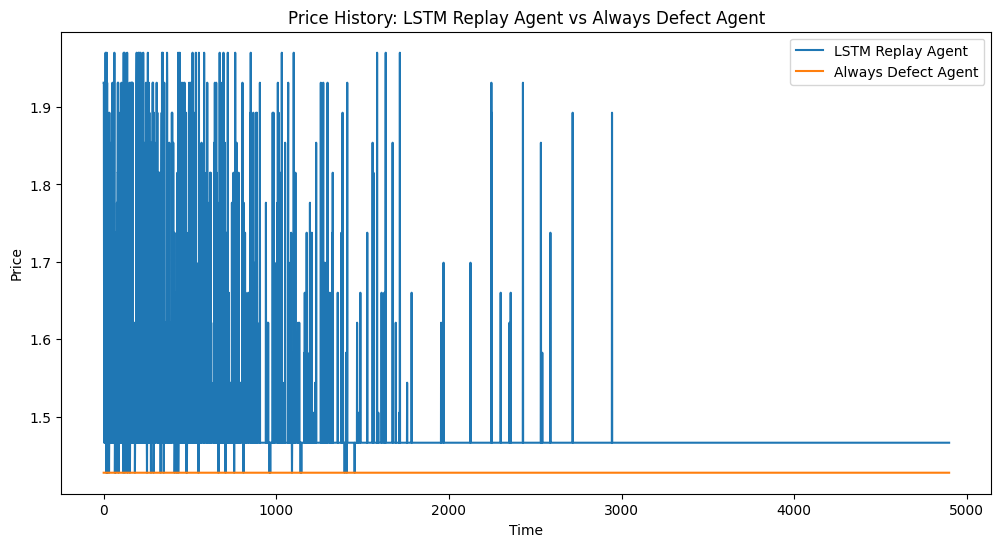

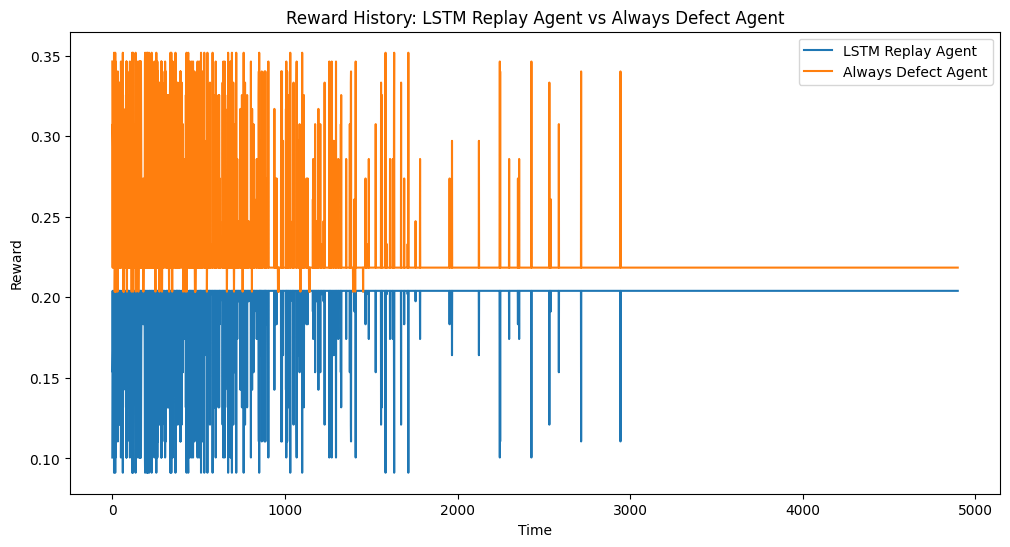

In [56]:
def test_lstm_replay_agent():
	# Create an environment with one LSTMReplayAgent and one AlwaysDefectAgent
	env = DiscreteSynchronEnvironment(
		markup=0.1,
		n_periods=5000,
		possible_prices=[],
		n_prices=15,
		demand=LogitDemand(outside_quality=0.0, price_sensitivity=0.25),
		history_after=100,
		agents=[
			LSTMReplayAgent(
				discount=0.95,
				learning_rate=0.01,
				decision=DecreasingEpsilonGreedy(),
				marginal_cost=1.0,
				quality=2.0,
				sequence_length=10,
				batch_size=32,
				update_target_after=250,
			),
			AlwaysDefectAgent(
				marginal_cost=1.0,
				quality=2.0,
			),
		],
	)

	# Simulate the environment
	env.play_game()

	# Analyze and visualize results
	price_history_lstm = [price[0] for price in env.price_history]
	price_history_defect = [price[1] for price in env.price_history]

	# Plot price history
	plt.figure(figsize=(12, 6))
	plt.plot(price_history_lstm, label="LSTM Replay Agent")
	plt.plot(price_history_defect, label="Always Defect Agent")
	plt.title("Price History: LSTM Replay Agent vs Always Defect Agent")
	plt.xlabel("Time")
	plt.ylabel("Price")
	plt.legend()
	plt.show()

	# Plot reward history
	reward_history_lstm = [reward[0] for reward in env.reward_history]
	reward_history_defect = [reward[1] for reward in env.reward_history]
	plt.figure(figsize=(12, 6))
	plt.plot(reward_history_lstm, label="LSTM Replay Agent")
	plt.plot(reward_history_defect, label="Always Defect Agent")
	plt.title("Reward History: LSTM Replay Agent vs Always Defect Agent")
	plt.xlabel("Time")
	plt.ylabel("Reward")
	plt.legend()
	plt.show()

test_lstm_replay_agent()